In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
plt.style.use('fivethirtyeight')

In [2]:
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 50)  # or 1000
pd.set_option('display.max_colwidth', 50)  # or 199

In [3]:
p = Path('./the_movie_dataset')

In [4]:
path = Path('./the_movie_dataset')
files = [p for p in path.glob('*.csv')]
files

[PosixPath('the_movie_dataset/links_small.csv'),
 PosixPath('the_movie_dataset/links.csv'),
 PosixPath('the_movie_dataset/credits.csv'),
 PosixPath('the_movie_dataset/date.csv'),
 PosixPath('the_movie_dataset/movies_metadata.csv'),
 PosixPath('the_movie_dataset/info_budget_1.csv'),
 PosixPath('the_movie_dataset/ratings.csv'),
 PosixPath('the_movie_dataset/info_budget_3.csv'),
 PosixPath('the_movie_dataset/info_budget_2.csv'),
 PosixPath('the_movie_dataset/ratings_small.csv'),
 PosixPath('the_movie_dataset/keywords.csv')]

# 0. Meta_data 기본적인 1차 수정
- id : links의 tmdbID를 의미한다.
- imdb_id : links의 imdbid와 일치 하지만 tt를 제거 해야한다.
- 기본적인 클리닝 수행함
    - imdb_id 수정
    - imdb_id 결측 제거(link와 일치 시킬 수가 없음)
    - 배급, 나라 정보 없는 영화 데이터는 이상한 값이 들어가 있음(3개) - 제거
    - original_language 정보 없는 11개 컬럼 spoken_languagers에서 1번 언어로 뽑아서 채워줌
    - 필요없는 컬럼 제거(홈페이지, 포스터 경로, tagline)

In [5]:
meta_data = pd.read_csv([f for f in files if 'metadata' in str(f)][0])

def cleaning_meta_data(df):
    
    df = df.copy()
    # 컬럼 이름 id = tmdbId
    df.rename({'id':'tmdbID'}, axis=1, inplace=True)
    
    
    # imdb_id 결측 17개 제거(어차피 못찾음)
    df = df.loc[~df['imdb_id'].isnull()]
    # 컬럼 imdb_id -> tt 제거하고 컬럼이름 imdbId로 link file과 index로 사용
    df['imdbId'] = df['imdb_id'].str.replace('tt','')
    
    
    
    # 배급, 나라 정보 없는 영화 3개인데  모든 정보가 없음
    df = df.loc[~df['production_companies'].isnull()]
    # spoken 결측 3개도 이상한 값으로 들어가 있음 제거
    df = df.loc[~df['spoken_languages'].isnull()]
    
    
    # original_language 정보 없는 11개 컬럼 spoken_languagers에서 1번 언어로 뽑아서 채워줌
    list_up = df[df['original_language'].isnull()].index
    for n,i in enumerate(df.loc[df['original_language'].isnull(),'spoken_languages']):
        cast = eval(i)
        lang = cast[0]['iso_639_1']
        df.loc[list_up[n],'original_language'] = lang
    
    # 필요없는 컬럼 제거 
    # tagline은 다른 정보로 대체 해야함, 결측이 너무 많음(절반이 결측)
    # revenue, budget은 크롤링 데이터로 대체
    cols = ['homepage','poster_path','tagline','imdb_id'
#             ,'adults'
#             ,'revenue'
#             ,'budget'
           ]
    df = df.drop(columns=cols)
    
    return df

meta_data = cleaning_meta_data(meta_data)

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
meta_data.loc[meta_data.tmdbID=='37900'] # 최종 shap에서 영화제목 찾기,,

,adult,belongs_to_collection,budget,genres,tmdbID,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,imdbId
7123,False,NaN,6000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",37900,en,Hell's Kitchen,"When a robbery goes awry, the bandits all end ...",2.973539,"[{'name': 'HK Film Corporation', 'id': 25988}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1998-09-11,0.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hell's Kitchen,False,5.4,12.0,0129136


In [6]:
meta_data.isnull().sum()

adult                        0
belongs_to_collection    40955
budget                       0
genres                       0
tmdbID                       0
original_language            0
original_title               0
overview                   952
popularity                   0
production_companies         0
production_countries         0
release_date                81
revenue                      0
runtime                    255
spoken_languages             0
status                      81
title                        0
video                        0
vote_average                 0
vote_count                   0
imdbId                       0
dtype: int64

In [490]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45443 entries, 0 to 45465
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45443 non-null  object 
 1   belongs_to_collection  4488 non-null   object 
 2   budget                 45443 non-null  object 
 3   genres                 45443 non-null  object 
 4   tmdbID                 45443 non-null  object 
 5   original_language      45443 non-null  object 
 6   original_title         45443 non-null  object 
 7   overview               44491 non-null  object 
 8   popularity             45443 non-null  object 
 9   production_companies   45443 non-null  object 
 10  production_countries   45443 non-null  object 
 11  release_date           45362 non-null  object 
 12  revenue                45443 non-null  float64
 13  runtime                45188 non-null  float64
 14  spoken_languages       45443 non-null  object 
 15  st

# 1. Movie Meta Date Cleaning & Feature engineering
## Step 1) Meta 데이터 클리닝

In [491]:
print(f'{meta_data.shape}')
print('장르 정보가 없는 영화 수 : ',len([g for g in meta_data['genres'] if len(g) < 10]))
print('배급사 정보가 없는 영화 수 : ',len([g for g in meta_data['production_companies'] if len(g) < 10]))
print('제작한 나라 정보가 없는 영화 수 : ',len([g for g in meta_data['production_countries'] if len(g) < 10]))
print('언어 정보가 없는 영화 수 : ',len([g for g in meta_data['spoken_languages'] if len(g) < 10]))
print('매출 정보가 없는 영화 수 : ',len([f for f in meta_data['revenue'] if f<1]))
print('예산 정보가 없는 영화 수 : ',len([f for f in meta_data['budget'] if int(f)<1]))

(45443, 21)
장르 정보가 없는 영화 수 :  2437
배급사 정보가 없는 영화 수 :  11865
제작한 나라 정보가 없는 영화 수 :  6274
언어 정보가 없는 영화 수 :  3822
매출 정보가 없는 영화 수 :  38035
예산 정보가 없는 영화 수 :  36555


### 1) adult & video
> adult, video는 범주 비율을 볼때, 정보가 없음 drop

In [492]:
print(meta_data['adult'].value_counts(dropna=False))
print(meta_data['video'].value_counts(dropna=False))

False    45434
True         9
Name: adult, dtype: int64
False    45350
True        93
Name: video, dtype: int64


### 2-1) original language
> original_language, 카디널리티 89,  거의 대부분의 비율이 english, 10작품 미만의 언어가 절반.  
> 전략 : 10작품 이하의 언어를 제 3세계 언어로 통합

10 작품 미만의 언어 수 : 41
5 작품 미만의 언어 수 : 32


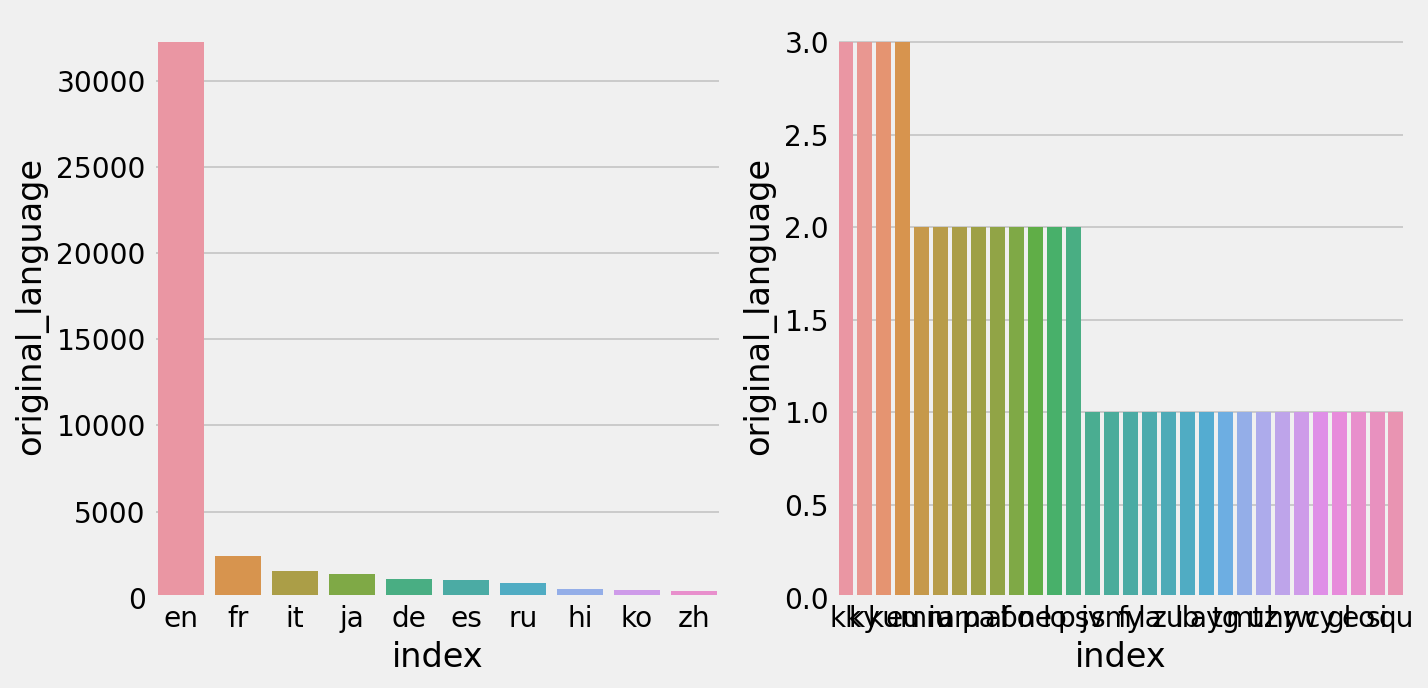

In [493]:
df_plt = meta_data['original_language'].value_counts(dropna=False).reset_index()
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data = df_plt
            ,x = df_plt['index'][:10], y=df_plt['original_language'][:10], ax=ax[0])
sns.barplot(data = df_plt
            ,x = df_plt['index'][-30:], y=df_plt['original_language'][-30:], ax=ax[1])
# 89개의 언어중 41개(약 절반)의 언어가 10편 미만
print('10 작품 미만의 언어 수 :',len(df_plt[df_plt['original_language']<10]))
print('5 작품 미만의 언어 수 :',len(df_plt[df_plt['original_language']<5]))

In [494]:
min_lang = meta_data['original_language'].value_counts(dropna=False)
min_lang = min_lang[min_lang<11].index.to_list()
min_lang_mapper = {i:'etc' for i in min_lang}

In [318]:
# 잘 들어가나 체크
meta_data['original_language'].map(min_lang_mapper).fillna(meta_data['original_language']).value_counts(dropna=False)

en     32257
fr      2438
it      1529
ja      1348
de      1082
es       994
ru       826
hi       508
ko       444
zh       409
sv       385
pt       316
cn       313
fi       297
nl       248
da       225
pl       217
tr       150
etc      141
cs       131
el       113
no       106
fa       101
hu       100
ta        78
th        76
he        67
sr        63
ro        57
te        45
ar        39
ml        36
xx        35
hr        29
bn        29
mr        25
is        24
et        24
tl        23
id        20
ka        18
lv        18
sl        17
uk        16
bs        14
ca        12
Name: original_language, dtype: int64

In [495]:
meta_data['original_language'] = meta_data['original_language'].map(min_lang_mapper).fillna(meta_data['original_language'])

### 2-2) Spoken languages
> 영화 내에서 사용된 언어 종류  
> 종류의 count만 사용함

In [496]:
meta_data['spoken_languages'] = ( meta_data['spoken_languages'].fillna('[]')
                                 .apply(ast.literal_eval)
                                 .apply(lambda x: len(x) if isinstance(x, list) else np.nan) )

### 3) 예산(budget)과 수익(revenue) 관련 처리
> 예산(budget)과 수익(revenue)의 경우 1/4정도만 데이터를 가지고 있음   
> 정보를 추가해 보기 위해 imdb 사이트 크롤링을 수행하였고, 5000건 이상의 데이터를 추가로 얻을 수 있었음  
> 또한, meta data의 budget 데이터의 단위가 통일되지 않은것을 발견하여 쓸 수없다고 판단.  
> 크롤링 데이터를 전처리해서 사용함



In [497]:
import re
# 크롤링 데이터 read
files_budget = [f for f in files if 'info_' in str(f)]

ff = (pd.read_csv(f, index_col=None, header=0) for f in files_budget)
budgets = pd.concat(ff, axis=0, ignore_index=True)
budgets.head()

,imdbId,budget,gross_usa,gross_world
0,tt0114709,"$30,000,000\n(estimated)\n","$223,225,679","$373,554,033"
1,tt0113497,"$65,000,000\n(estimated)\n","$100,499,940","$262,797,249"
2,tt0113228,"$25,000,000\n(estimated)\n","$71,518,503","$71,518,503"
3,tt0114885,"$16,000,000\n(estimated)\n","$67,052,156","$81,452,156"
4,tt0113041,"$30,000,000\n(estimated)\n","$76,594,107","$76,594,107"


In [498]:
# 예산이 달러가 아닌 경우가 꽤 있음
for i in [f for f in budgets['budget'] if ('DEM' in f)]:
    print(budgets[budgets['budget']==i])

        imdbId                        budget   gross_usa gross_world
299  tt0110963  DEM42,000,000\n(estimated)\n  $1,304,237  $1,318,578
        imdbId                       budget gross_usa gross_world
614  tt0102855  DEM6,340,000\n(estimated)\n        []          []
        imdbId                        budget gross_usa gross_world
647  tt0117117  DEM11,500,000\n(estimated)\n        []          []
          imdbId                        budget gross_usa gross_world
746    tt0108211  DEM20,000,000\n(estimated)\n  $152,972    $152,972
14466  tt0052924  DEM20,000,000\n(estimated)\n    $4,673      $4,673
         imdbId                     budget gross_usa gross_world
856   tt0075169  DEM600,000\n(estimated)\n        []          []
9990  tt0075165  DEM600,000\n(estimated)\n    $8,144      $8,144
         imdbId                        budget    gross_usa  gross_world
1205  tt0082096  DEM32,000,000\n(estimated)\n  $11,487,676  $11,487,676
          imdbId                       budget   gr

- 각 나라 단위로 되어 있는 budget을 달러로 통일 하기 위해서 currency mapping
- 현재 시점의 us달러 환율로 변환하지만, 시간점에 따라서 환율이 달랐을 것이기 때문에 정확하지는 않음
- 어쩔 수 없는 부분..

In [499]:
currency = {
             'AMD': 0.0019,
             'ARS': 0.011,
             'ATS': 0.088,
             'AUD': 0.79,
             'BEF': 0.12,
             'BGL': (0.6/20),
             'BND': 0.75,
             'BRL': 0.19,
             'CAD': 0.79,
             'CHF': 1.11,
             'CLP': 0.0014,
             'CNY': 0.15,
             'COP': 0.00028,
             'CZK': 0.047,
             'DEM': 0.62,
             'DKK': 0.16,
             'EEK': (0.78/10),
             'EGP': 0.064,
             'ESP': (0.73/100),
             'EUR': 1.21,
             'FIM': (4.08/20),
             'FRF': (3.70/20),
             'GBP': 1.40,
             'HKD': 0.13,
             'HRK': 0.16,
             'HUF': 0.0034,
             'IDR': 0.000071,
             'IEP': 1.54,
             'ILS': 0.31,
             'INR': 0.014,
             'IRR': 0.000024,
             'ISK': 0.0078,
             'ITL': (6.27/10),
             'JMD': 0.0066,
             'JPY': 0.0095,
             'KRW': 0.0009,
             'LTL': 2.89,
             'LVL': (165.32/100),
             'MXN': 0.048,
             'MYR': 0.25,
             'NGN': 0.0024,
             'NLG': 0.54,
             'NOK': 0.12,
             'NZD': 0.73,
             'PHP': 0.021,
             'PKR': 0.0063,
             'PLN': 0.27,
             'PTE': (1.21/200),
             'ROL': 0.25,
             'RUR': 0.013,
             'SEK': 0.12,
             'SGD': 0.75,
             'SIT': (50.66/10000),
             'THB': 0.033,
             'TRL': 0.14,
             'TWD': 0.036,
             'UAH': 0.036,
             'VEB': np.nan,
             'XAU': np.nan,
             'ZAR': 0.067
        }

In [323]:
# dollor 단위 아닌 화폐 종류 get
not_Dollor = [f for f in budgets['budget'] if ('$' not in f and '[]' not in f)]
kind_of_bills = set([f[:3] for f in not_Dollor])
kind_of_bills

{'AMD',
 'ARS',
 'ATS',
 'AUD',
 'BEF',
 'BGL',
 'BND',
 'BRL',
 'CAD',
 'CHF',
 'CLP',
 'CNY',
 'COP',
 'CZK',
 'DEM',
 'DKK',
 'EEK',
 'EGP',
 'ESP',
 'EUR',
 'FIM',
 'FRF',
 'GBP',
 'HKD',
 'HRK',
 'HUF',
 'IDR',
 'IEP',
 'ILS',
 'INR',
 'IRR',
 'ISK',
 'ITL',
 'JMD',
 'JPY',
 'KRW',
 'LTL',
 'LVL',
 'MXN',
 'MYR',
 'NGN',
 'NLG',
 'NOK',
 'NZD',
 'PHP',
 'PKR',
 'PLN',
 'PTE',
 'ROL',
 'RUR',
 'SEK',
 'SGD',
 'SIT',
 'THB',
 'TRL',
 'TWD',
 'UAH',
 'VEB',
 'XAU',
 'ZAR'}

In [500]:
def cleaning_budget(x):
    
    if x =='[]': # 정보 없는 빈칸 -> nan
        return np.nan
    
    budget = x.split('\n')[0].replace('$','').replace(',','')
    
    try :
        budget = int(budget)
        
        if budget == 0: # $0 이렇게 표시된 곳도 있음 -> nan
            budget = np.nan
            
    except :
        
        kind_of_bill = x.split('\n')[0].replace('%','').replace(',','')[:3]
        exchange_ = currency.get(kind_of_bill, 1) # 3번째 자리에 화폐단위가 있으면 환율, 없으면 그냥 달러
        # 달러 환율 곱해서 돌려줌
        budget = int(x.split('\n')[0].replace('%','').replace(',','')[3:]) * exchange_ 
        
        if budget == 0: # $KRW0 이런곳도 있음 -> nan
            budget = np.nan
            
    return budget

budgets['budget'] = budgets['budget'].apply(lambda x: cleaning_budget(x))
budgets['gross_usa'] = budgets['gross_usa'].apply(lambda x: cleaning_budget(x))
budgets['gross_world'] = budgets['gross_world'].apply(lambda x: cleaning_budget(x))

# incomes = 투자대비 흥행달러
budgets['incomes'] = budgets['gross_world'] / budgets['budget']
print('투자대비 수익 정보 없는 영화:',budgets['incomes'].isnull().sum())

투자대비 수익 정보 없는 영화: 35911


/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='incomes', ylabel='Density'>

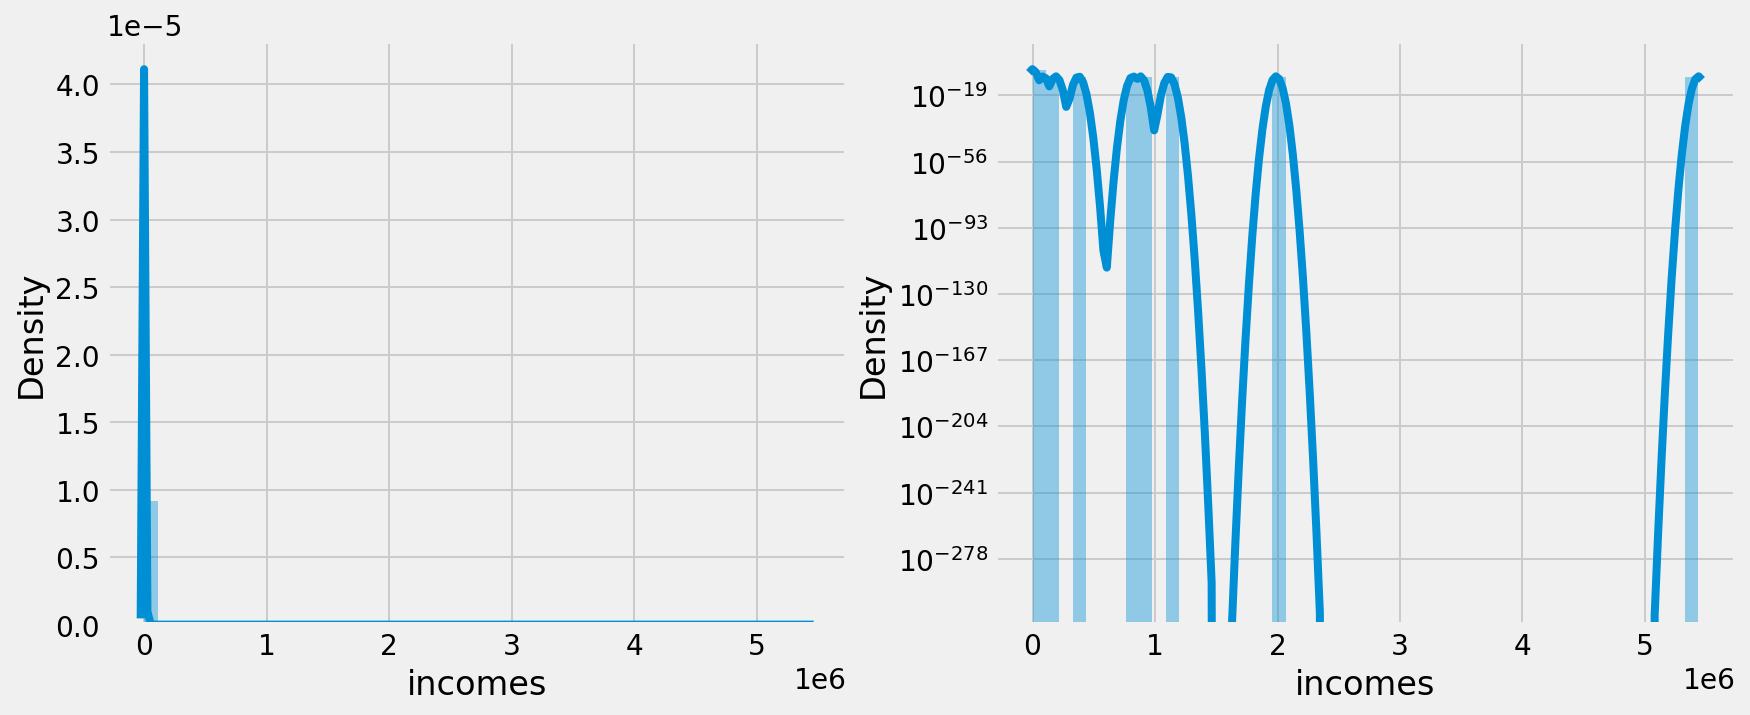

In [501]:
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.distplot(budgets['incomes'],ax=ax[0])
sns.distplot(budgets['incomes'],ax=ax[1], hist_kws={'log':True})

#### ***기존 meta data 파일이 가지고 있던 정보에 비해 약 5000건 이상의 데이터를 더 확보할 수 있었음***

### 4) genres 장르
- 장르 tag가 여러개로 되어 있는 경우가 대부분
- tag가 없는 경우도 있음
- meta_data는 tmdb api에 기반하기 때문에 movie_len의 tag와는 구분됨
- genres_tmdb tmdb 장르 tag를 지정
- genres_tmdb 장르 tag수 기반으로 장르 복잡성 특성 만듬

### 5) belongs to collection
- 특정 시리즈에 속해 있는 영화에 대한 정보 ex) 007, 해리포터 등등..
- 1개만 속해 있느 시리즈도 꽤 있음(388개)
- collection or not in collenction 으로 분류할지 고민

In [502]:
print('장르 tag 없는 영화 수 :',len([i for i in meta_data['genres'] if len(i)<10 ]))

장르 tag 없는 영화 수 : 2437


In [503]:
def extract_genres(x):
    
    cast = [i['name'] for i in ast.literal_eval(x)] # eval 보다 안전한 방법
    if len(cast) == 0:
        return np.nan
    else :
        for n,i in enumerate(cast):
            if n < 1:
                ss = i
            else :
                ss = ss+'|'+i
        return ss

def number_of_genres(x):
    try :
        return len(x.split('|'))
    except :
        return 0
# 장르 꺼내기
meta_data['genres_tmdb'] = meta_data['genres'].apply(lambda x: extract_genres(x))
# 장르 tag count -> 복잡성
meta_data['genres_tmdb_complexity'] = meta_data['genres_tmdb'].apply(lambda x: number_of_genres(x))
meta_data.head()

,adult,belongs_to_collection,budget,genres,tmdbID,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,imdbId,genres_tmdb,genres_tmdb_complexity
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,1,Released,Toy Story,False,7.7,5415.0,0114709,Animation|Comedy|Family,3
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,2,Released,Jumanji,False,6.9,2413.0,0113497,Adventure|Fantasy|Family,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,1,Released,Grumpier Old Men,False,6.5,92.0,0113228,Romance|Comedy,2
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,1,Released,Waiting to Exhale,False,6.1,34.0,0114885,Comedy|Drama|Romance,3
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,1,Released,Father of the Bride Part II,False,5.7,173.0,0113041,Comedy,1


In [504]:
def collections(x):
    if x == '[]':
        return 'none_collection'
    else :
        return ast.literal_eval(x).get('name')

meta_data['collection'] = meta_data['belongs_to_collection'].fillna('[]').apply(lambda x: collections(x))



In [505]:
c = meta_data['collection'].replace('none_collection',np.nan).value_counts() > 2
meta_data['collection'].replace('none_collection',np.nan).value_counts()[c]

The Bowery Boys                                      29
Totò Collection                                      27
James Bond Collection                                26
Zatôichi: The Blind Swordsman                        26
The Carry On Collection                              25
                                                     ..
The Musketeers Collection                             3
男はつらいよ シリーズ                                           3
Creature From The Black Lagoon (Universal Series)     3
Missing in Action Collection                          3
A Chinese Ghost Story Collection                      3
Name: collection, Length: 627, dtype: int64

In [286]:
meta_data.head(2).T

,0,1
adult,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN
budget,30000000,65000000
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
tmdbID,862,8844
original_language,en,en
original_title,Toy Story,Jumanji
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...
popularity,21.946943,17.015539
production_companies,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'name': 'TriStar Pictures', 'id': 559}, {'na..."


### 6) production companies
- 정보가 없는(제작 회사 정보가 없음) 데이터 & 제작 회사 1개 & 1개 이상 데이터의 수가 비슷비슷한 비율로 구성
- 제작사가 여럿이면 첫 번째 제작사 이름을 대표로 사용
- 제작사 count를 남겨둠
- 정보 없는 경우는 결측으로(나중에 encoder, imputer에서 처리)
- ***제작사의 카디널리티가 매우 높기 때문에 10개 이하 작품을 가진 제작사는 etc로 묶음***

### 7) production countries
- 여러 국가에서 제각한 경우도 있음, 1개 이상 국가 데이터 7000건 정도
- 제작 국가 정보가 없는 데이터 6000건 정도
- 대부분 1개 국가에서 제작
- 위와 동일하게 첫 번째 데이터를 대표 국가로 사용
- 제작 국가의 count를 남겨둠
- ***거의 대부분이 영국과 미국이지만 일단 median 값을 기준으로 etc국가 분류***

In [506]:
# 제작사의 수를 count
meta_data['n_production_companies'] = ( meta_data['production_companies'].apply(ast.literal_eval)
                                        .apply(lambda x : len(x) if isinstance(x, list) else np.nan))

In [507]:
def companies(x):
    cast = ast.literal_eval(x)
    if len(cast) < 1:
        return np.nan
    else :
        return cast[0].get('name')
    
# main_production_companies = 첫 번째 제작사를 main으로
meta_data['main_production_companies'] = meta_data['production_companies'].apply(lambda x: companies(x))

In [508]:
min_comp = meta_data['main_production_companies'].value_counts(dropna=False)
min_comp = min_comp[min_comp<11].index.to_list()
min_comp_mapper = {i:'etc' for i in min_comp}
min_comp_mapper

meta_data['main_production_companies'] = ( meta_data['main_production_companies']
                                          .map(min_comp_mapper) # 정의한 mapper로 dic mapping
                                          .fillna(meta_data['main_production_companies']) # ampping에 없는 건 원래 값으로 채움 
                                         )

In [411]:
min_comp_mapper

{'Mars Films': 'etc',
 'Hemdale Film': 'etc',
 'Brandman Productions': 'etc',
 'HBO Documentary Films': 'etc',
 'Studio 4°C': 'etc',
 'Coop 99': 'etc',
 'Česká televize': 'etc',
 'Parts and Labor': 'etc',
 '20th Century Pictures': 'etc',
 'XYZ Films': 'etc',
 'Whitewater Films': 'etc',
 'New Zealand Film Commission': 'etc',
 'Production I.G.': 'etc',
 'Fox Star Studios': 'etc',
 'Finos Film': 'etc',
 'Boll Kino Beteiligungs GmbH & Co. KG': 'etc',
 'American Broadcasting Company (ABC)': 'etc',
 'Solar Productions': 'etc',
 'Pathé Distribution': 'etc',
 'Dark Castle Entertainment': 'etc',
 'Fono Roma': 'etc',
 'Vía Digital': 'etc',
 'WGBH': 'etc',
 'Tokyo Broadcasting System (TBS)': 'etc',
 'Eskwad': 'etc',
 'Paradis Films': 'etc',
 'Instituto Cubano del Arte e Industrias Cinematográficos (ICAIC)': 'etc',
 'Showbox': 'etc',
 'Les Films Corona': 'etc',
 'Walt Disney Television Animation': 'etc',
 'Versus Production': 'etc',
 'Shooting Gallery': 'etc',
 'WDR': 'etc',
 'Epic Productions': '

In [509]:
# 카디널리티 해소
meta_data['main_production_companies'].nunique()

373

In [338]:
c = ( meta_data['production_countries'].apply(ast.literal_eval)
                                        .apply(lambda x : len(x) if isinstance(x, list) else np.nan)>1)
meta_data[c]

,adult,belongs_to_collection,budget,genres,tmdbID,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,imdbId,genres_tmdb,genres_tmdb_complexity,collection,n_production_companies,main_production_companies
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",11860,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1995-12-15,0.0,127.0,2,Released,Sabrina,False,6.2,141.0,0114319,Comedy|Romance,2,none_collection,7,Paramount Pictures
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",710,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,3,Released,GoldenEye,False,6.6,1194.0,0113189,Adventure|Action|Thriller,3,James Bond Collection,2,United Artists
11,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",12110,en,Dracula: Dead and Loving It,When a lawyer shows up at the vampire's doorst...,5.430331,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,0.0,88.0,2,Released,Dracula: Dead and Loving It,False,5.7,210.0,0112896,Comedy|Horror,2,none_collection,3,Columbia Pictures
14,False,NaN,98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",1408,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",7.284477,"[{'name': 'Le Studio Canal+', 'id': 183}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,10017322.0,119.0,2,Released,Cutthroat Island,False,5.7,137.0,0112760,Action|Adventure,2,none_collection,4,etc
15,False,NaN,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",524,en,Casino,The life of the gambling paradise – Las Vegas ...,10.137389,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-11-22,116112375.0,178.0,1,Released,Casino,False,7.8,1343.0,0112641,Drama|Crime,2,none_collection,4,Universal Pictures
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45421,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",52103,zh,Xiao Wu,Little pocket thief Wu never got away from the...,0.350365,"[{'name': 'Hu Tong Communications', 'id': 1452...","[{'iso_3166_1': 'CN', 'name': 'China'}, {'iso_...",1997-01-01,0.0,105.0,1,Released,Pickpocket,False,7.2,13.0,0144020,Drama|Foreign,2,none_collection,2,etc
45424,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}]",42652,ru,Uznik Zamka If,A Russian version of the classic Alexandre Dum...,0.243401,"[{'name': 'Odessa Film Studios', 'id': 13852}]","[{'iso_3166_1': 'UA', 'name': 'Ukraine'}, {'is...",1988-01-01,0.0,270.0,1,Released,The Prisoner of If Castle,False,5.0,3.0,0096356,Adventure,1,none_collection,1,Odessa Film Studios
45436,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 9648, 'n...",45527,en,The Final Storm,A stranger named Silas flees from a devastatin...,1.270832,[{'name': 'Boll Kino Beteiligungs GmbH & Co. K...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2010-01-01,0.0,92.0,1,Released,The Final Storm,False,3.7,11.0,1331329,Action|Mystery|Thriller|Horror,4,none_collection,4,etc
45441,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",14008,en,Cadet Kelly,Hyperactive teenager Kelly is enrolled into a ...,4.392389,"[{'name': 'Walt Disney Television', 'id': 670}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2002-03-07,0.0,101.0,1,Released,Cadet Kelly,False,5.2,145.0,0294425,Comedy,1,none_collection,3,Walt Disney Television


In [510]:
# 첫 번째 제작 국가를 main으로, 제작 국가의 수를 count
meta_data['n_production_countries'] = ( meta_data['production_countries'].apply(ast.literal_eval)
                                        .apply(lambda x : len(x) if isinstance(x, list) else np.nan))
meta_data['main_production_countries'] = meta_data['production_countries'].apply(lambda x: companies(x))

In [511]:
meta_data['main_production_countries'].value_counts(dropna=False)

United States of America    18422
NaN                          6274
United Kingdom               3069
France                       2703
Canada                       1498
                            ...  
Liechtenstein                   1
Myanmar                         1
Bermuda                         1
Namibia                         1
Samoa                           1
Name: main_production_countries, Length: 144, dtype: int64

In [512]:
cutoff = meta_data['main_production_countries'].value_counts().reset_index().median().values[0]
min_countrie = meta_data['main_production_countries'].value_counts(dropna=False)
min_countrie = min_countrie[min_countrie<cutoff].index.to_list()
min_countrie_mapper = {i:'etc' for i in min_countrie}
min_countrie_mapper

meta_data['main_production_countries'] = ( meta_data['main_production_countries']
                                          .map(min_countrie_mapper) # 정의한 mapper로 dic mapping
                                          .fillna(meta_data['main_production_countries']) # ampping에 없는 건 원래 값으로 채움 
                                         )

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

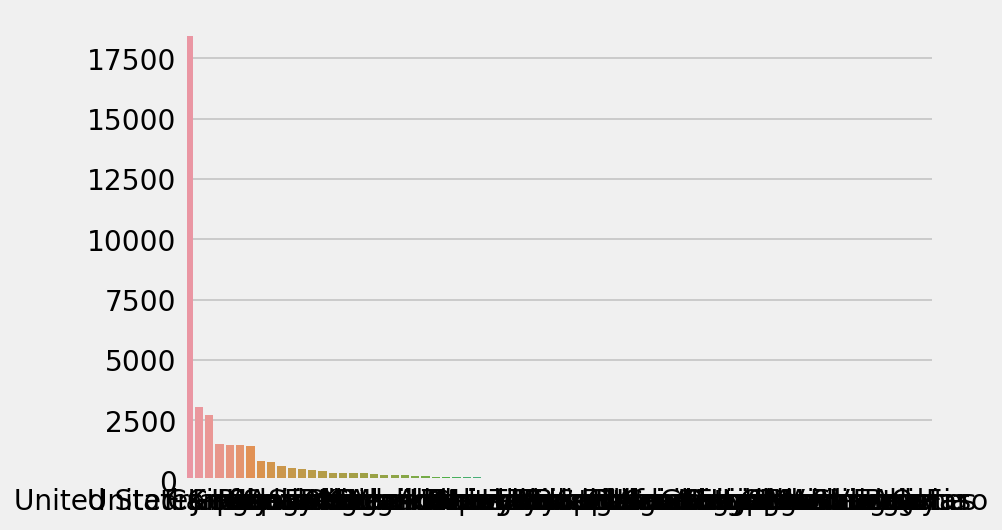

In [513]:
sns.barplot(meta_data['main_production_countries'].value_counts().index, 
            meta_data['main_production_countries'].value_counts().values)

In [514]:
# 73개로 줄임
cc = meta_data['main_production_countries'].value_counts().reset_index()
cc.shape

(73, 2)

### 8) release date
- 개봉일 정보가 없는 영화 81개 크롤링으로 채워 넣음 그래도 11개는 찾지 못함
- 개봉년도와 개봉 월 정보를 남겨둠,
- 개봉 월 정보가 없는 몇 영화의 경우 1월으로 처리

In [515]:
no_date_id = ( meta_data
              .loc[pd.to_datetime(meta_data['release_date'])
                   .dt.year.isnull(),'imdbId']
              .reset_index() ) # index 정보 가지고 나중에 merge
no_date_id.to_csv('date_info.csv')

In [516]:
# 개봉 년도, 월
meta_data['year'] = pd.to_datetime(meta_data['release_date']).dt.year
meta_data['month'] = pd.to_datetime(meta_data['release_date']).dt.month

In [517]:
# 크롤링 데이터 read
append_date = pd.read_csv([f for f in files if 'date.csv' in str(f)][0])
append_date['year'] = pd.to_datetime(append_date['date']).dt.year
append_date['month'] = pd.to_datetime(append_date['date']).dt.month
append_date['imdbId'] = append_date['imdbId'].str.replace('tt','')
append_date.set_index('index', inplace=True)

In [518]:
append_date.head(3)

,imdbId,date,year,month
index,,,,
711,0114894,9 May 1996,1996.0,5.0
734,0105737,25 September 1992,1992.0,9.0
3460,0210130,May 2000,2000.0,5.0


In [519]:
# meta_data.loc[meta_data['year'].isna(),'year'] = ( meta_data.merge(append_date, 
#                                                                    how='left', 
#                                                                    on='imdbId')['year_y'] )

# 위 nan value를 채우는 merge가 잘 작동하지 않아서
# csv파일 만들 때, 가지고 있던 index 사용해서 값을 넣어줌
for n,i in enumerate(append_date.index):
#     print(i)
    meta_data.loc[append_date.index[n],'year'] = append_date.loc[append_date.index[n],'year']
    meta_data.loc[append_date.index[n],'month'] = append_date.loc[append_date.index[n],'month']

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='year', ylabel='Density'>

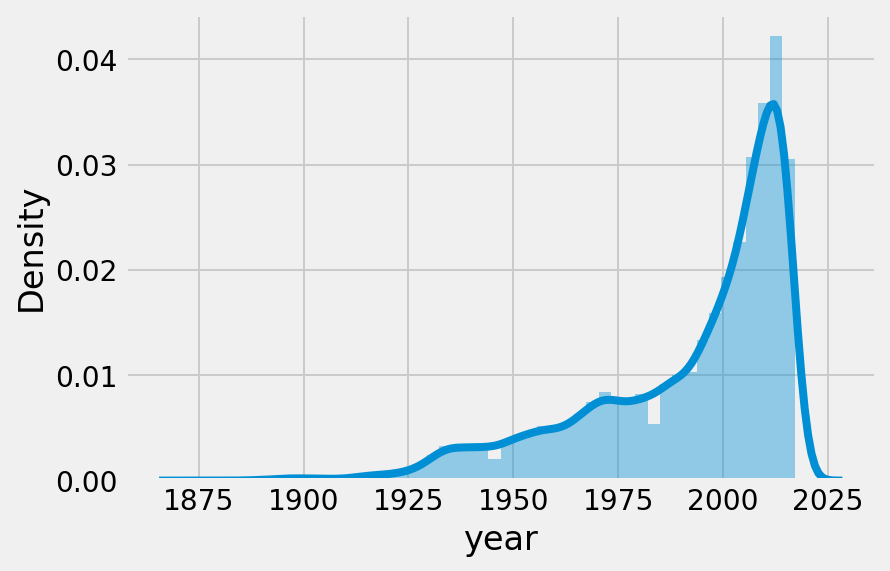

In [520]:
sns.distplot(meta_data['year'])

### 9) status
- 영화가 실제로 개봉하지 않거나, 계획만 있는 경우와 같은 상태를 나타냄
- 큰 도움이 안될 수 있으나, category수가 많지 않아 남겨둠

In [521]:
meta_data['status'].value_counts(dropna=False)

Released           44999
Rumored              228
Post Production       98
NaN                   81
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

## Step 2) Final cleaning & merge budget data

In [526]:
def cleaning_meta_data_columns(df):
    
    df = df.copy()
    # 필요없는 컬럼 제거 
    cols = ['adult', 'belongs_to_collection', 'budget', 'genres',
           'production_companies', 'production_countries', 'release_date',
           'revenue','title', 'video'
           ,'overview'
           ]
    df = df.drop(columns=cols)
    
    return df

meta_data_preprocessed = cleaning_meta_data_columns(meta_data)
print(meta_data_preprocessed.shape, budgets.shape)

budgets['imdbId'] = budgets['imdbId'].str.replace('tt','')
print(budgets.head(2))

# merge incomes
meta_data_preprocessed = ( meta_data_preprocessed
                          .merge(budgets[['imdbId','budget','gross_world','incomes']],how='left', on='imdbId') )
print(meta_data_preprocessed.shape, budgets.shape)

(45443, 19) (45836, 5)
    imdbId      budget    gross_usa  gross_world    incomes
0  0114709  30000000.0  223225679.0  373554033.0  12.451801
1  0113497  65000000.0  100499940.0  262797249.0   4.043035
(45443, 22) (45836, 5)


---


## Step 3) Get rating data from movie len user ratings!
#### ***movie len data에서 user의 rating 정보를 가져옴***

In [527]:
ml = Path('./ml-latest')
ml_files = [g for g in ml.glob('*.csv')]
ml_files

[PosixPath('ml-latest/links.csv'),
 PosixPath('ml-latest/tags.csv'),
 PosixPath('ml-latest/genome-tags.csv'),
 PosixPath('ml-latest/ratings.csv'),
 PosixPath('ml-latest/genome-scores.csv'),
 PosixPath('ml-latest/movies.csv')]

In [528]:
# rating 정보
rating = pd.read_csv([f for f in ml_files if 'ratings' in str(f)][0])
ml_links = pd.read_csv([f for f in ml_files if 'links' in str(f)][0],
                       dtype={'imdbId':'str','tmdbId':'str'})
g = rating.groupby('movieId')['rating'].mean()

# 영화별로 평균 & link에 merge
ml_links = ml_links.merge(g, how='left', on='movieId')

# meta_data에 rating 점수 merge
meta_data_preprocessed = meta_data_preprocessed.merge(ml_links, how='left', on='imdbId')
print('rating 점수 없는 영화:',meta_data_preprocessed['rating'].isna().sum())
print(meta_data_preprocessed.shape)

rating 점수 없는 영화: 615
(45443, 25)


***615개 영화에 rating점수 없음***   
***이후, 드랍처리***

/Users/gray/Desktop/ai_local/.conda-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


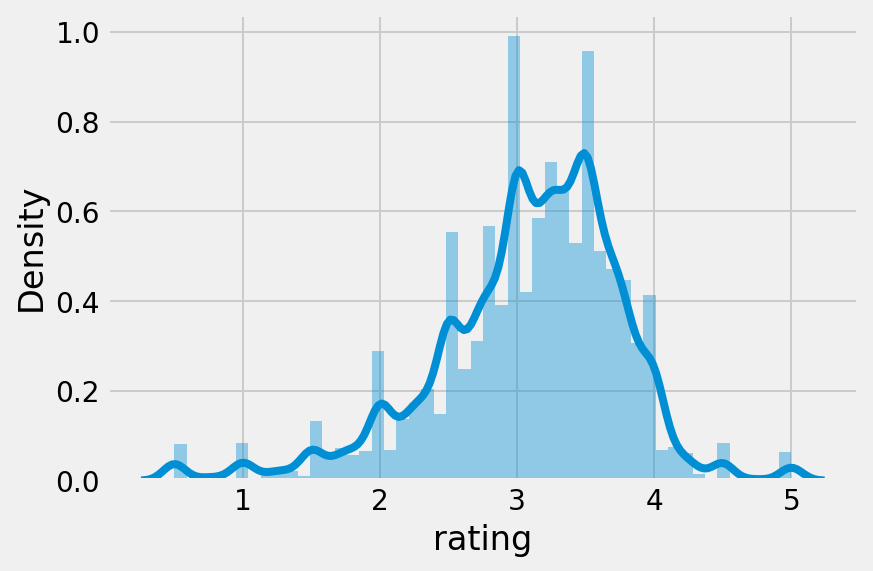

In [529]:
sns.distplot(meta_data_preprocessed['rating']);

In [ ]:
# 간단한 모델 학습은 다른 노트북에서,, 너무 길어서 지저분
# meta_data_preprocessed.to_csv('preprocessed_meta_data.csv')

# 2. Movie credits from tmdb api & Keywords from tmdb, movie-len

## 1. Credits : 배우 & 스텝 
- 여기도 id = tmdbId를 의미함, meta data에서 str로 되어있기 때문에 통일
- 4만개 중 정보 없는 수가 많지는 않음
- 주연배우만 해도 1만8천명의 카디널리티가 있음
- 개별 배우의 수상이력을 사용해서 새로운 지표를 만들 필요가 있음
    - 위키에서 긁어오는 데이터로 데이터를 만들 것
- 스텝의 수를 count해서 영화의 규모를 proxi하는 지표로 삼을 것
- 감독은 따로 빼서 저장(중요한 포인트이기 때문)

In [530]:
credits = pd.read_csv([f for f in files if 'credits' in str(f)][0], dtype={'id':'str'})
credits.rename({'id':'tmdbId'},axis=1, inplace=True)
print(credits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   tmdbId  45476 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
None


In [531]:
print('cast에서 값이 없는 수 :',len([c for c in credits['cast'] if len(c) < 10 ]))
print('crew 값이 없는 수 :',len([c for c in credits['crew'] if len(c) < 10 ]))

cast에서 값이 없는 수 : 2418
crew 값이 없는 수 : 771


In [434]:
credits['cast'].isnull().sum()

0

#### # 5번째 배우까지 선택, 5명의 성별, 이름을 추출 - 3명까지로 제한 너무많음

In [532]:
credits['cast_main_5'] = ( credits['cast'].apply(ast.literal_eval)
                            .apply(lambda x: [ x['name'] for x in x[:3]] ) )
credits['cast_main_5_gender'] = ( credits['cast'].apply(ast.literal_eval)
                            .apply(lambda x: [ x['gender'] for x in x[:3]] ) )
credits[['actor_1_name',
         'actor_2_name',
         'actor_3_name']] = ( credits['cast_main_5']
                             .apply(lambda x: pd.Series(x)) )


credits[['actor_1_gender',
         'actor_2_gender',
         'actor_3_gender']] = ( credits['cast_main_5_gender']
                             .apply(lambda x: pd.Series(x)) )


<ipython-input-532-78f3b5ab4e40>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(lambda x: pd.Series(x)) )
<ipython-input-532-78f3b5ab4e40>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(lambda x: pd.Series(x)) )


In [231]:
credits.head(3)

,cast,crew,tmdbId,cast_main_5,cast_main_5_gender,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom Hanks, Tim Allen, Don Rickles]","[2, 2, 2]",Tom Hanks,Tim Allen,Don Rickles,2.0,2.0,2.0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[2, 2, 1]",Robin Williams,Jonathan Hyde,Kirsten Dunst,2.0,2.0,1.0
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[2, 2, 1]",Walter Matthau,Jack Lemmon,Ann-Margret,2.0,2.0,1.0


#### # 위키api를 활용해서, unique 배우 7만명의 수상(won), 노미네이트(nominate) count! 위키 api밴먹고 다시 하는중
- 한계점은 있음, 미국 위키를 기준으로 하기 때문에 헤외 배우들의 정보가 누락된게 많고, wiki text에서 단순히 단어 won, nominate를 count하기 때문에 정확하지는 않음.
- 하지만 어느정도 배우의 수상경력을 반영하는 지표로 삼을 수 있을 것임.


In [436]:
unique_actors = set([item for sublist in credits['cast_main_5'].to_list() for item in sublist])
unique_actors = dict.fromkeys(unique_actors, 0) 
list(unique_actors)[:5]

['Jacek Fedorowicz',
 'Tôru Masuoka',
 'Tamara Davies',
 'François Bégaudeau',
 'Paola Rinaldi']

***위키 api ip밴당했나***

In [59]:
import wikipediaapi
wiki = wikipediaapi.Wikipedia(language='en',extract_format=wikipediaapi.ExtractFormat.WIKI)
page = wiki.page('Lois Nettleton')
t = page.text
print(t.count('won'), t.count('nominat'))
for name in list(unique_actors)[:20]:
    
    page = wiki.page(name)
    
    if len(page.categories) < 5:
        name = name + ' (actor)'
        page = wiki.page(name)
        unique_actors[name] = (0, 0)
    else :
        t = page.text
        unique_actors[name] = (t.count('won'), t.count('nominat'))


#### # Crew의 숫자를 단순 count해서 영화의 규모를 반영한 feature 생성
- 크루 정보가 없으면 0

In [533]:
# number of crew 정보가 없으면 nan
credits['n_crew'] = ( 
                        credits['crew'].apply(ast.literal_eval)
                        .apply(lambda x: len(x) if isinstance(x, list) else np.nan) # eval로 반환된 x가 list면 crew의 수
                    )

In [438]:
credits['n_crew']

0        106
1         16
2          4
3         10
4          7
        ... 
45471      9
45472      6
45473      5
45474      2
45475      1
Name: n_crew, Length: 45476, dtype: int64

#### # 감독 이름은 따로 지정 (후에 감독별 수상이력 추가)

In [439]:
ast.literal_eval(credits['crew'][1])[0]

{'credit_id': '52fe44bfc3a36847f80a7cd1',
 'department': 'Production',
 'gender': 2,
 'id': 511,
 'job': 'Executive Producer',
 'name': 'Larry J. Franco',
 'profile_path': None}

In [534]:
credits['Producer'] = ( 
                    credits['crew'].apply(ast.literal_eval) 
                   .apply(lambda x: x[0]['name'] if len(x)>1 else np.nan) # 반환된 리스트의 element가 없으면, 정보가 없는 경우
                  )

In [535]:
credits['Producer'].value_counts()

Avy Kaufman           124
Ennio Morricone        81
Suzanne Smith          69
Roger Corman           65
Max Steiner            51
                     ... 
Nathan Halpern          1
Daniele Gaglianone      1
Yoram Ben-Ami           1
Fernando Caruso         1
Vidyasagar              1
Name: Producer, Length: 18428, dtype: int64

## 2. Keywords & Tags
- 키워드 결측이 너무 많음 1/4가 결측

In [121]:
files

[PosixPath('the_movie_dataset/links_small.csv'),
 PosixPath('the_movie_dataset/links.csv'),
 PosixPath('the_movie_dataset/credits.csv'),
 PosixPath('the_movie_dataset/date.csv'),
 PosixPath('the_movie_dataset/movies_metadata.csv'),
 PosixPath('the_movie_dataset/info_budget_1.csv'),
 PosixPath('the_movie_dataset/ratings.csv'),
 PosixPath('the_movie_dataset/info_budget_3.csv'),
 PosixPath('the_movie_dataset/info_budget_2.csv'),
 PosixPath('the_movie_dataset/ratings_small.csv'),
 PosixPath('the_movie_dataset/keywords.csv')]

In [239]:
keywords = pd.read_csv([f for f in files if 'keywords' in str(f)][0], dtype={'id':'str'}) # dtype={'imdbId':'str','tmdbId':'str'}
keywords.rename({'id':'tmdbId'}, axis=1, inplace=True)

In [240]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tmdbId    46419 non-null  object
 1   keywords  46419 non-null  object
dtypes: object(2)
memory usage: 725.4+ KB


In [241]:
print('키워드 없는 수:',len([k for k in keywords['keywords'] if len(k)<10 ]))

키워드 없는 수: 14795


In [242]:
keywords

,tmdbId,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [127]:
ml_files

[PosixPath('ml-latest/links.csv'),
 PosixPath('ml-latest/tags.csv'),
 PosixPath('ml-latest/genome-tags.csv'),
 PosixPath('ml-latest/ratings.csv'),
 PosixPath('ml-latest/genome-scores.csv'),
 PosixPath('ml-latest/movies.csv')]

#### tag는 유저들이 자유롭게 영화에 대해서 붙인 tag, 종류가 매우 다양함, 분류하기 엉청 힘들 것 같음

In [129]:
tags = pd.read_csv([f for f in ml_files if 'tags' in str(f)][0])

In [141]:
tags

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


In [136]:
tags['tag'].value_counts()[(tags['tag'].value_counts() > 1000)]

sci-fi         9400
atmospheric    6430
action         6219
comedy         5923
surreal        5299
               ... 
futuristic     1008
intelligent    1008
racism         1004
Brad Pitt      1003
military       1001
Name: tag, Length: 137, dtype: int64

#### 개별 movieID에 782개 tag가 달려 있는 걸 볼 수 있음,   이걸 축소하는 방법을 찾아야함, 단어간 유사도? 같은걸로

In [142]:
tags[tags['movieId']==1]

,userId,movieId,tag,timestamp
1775,1040,1,animated,1514919574
1776,1040,1,buddy movie,1514919577
1777,1040,1,Cartoon,1514919589
1778,1040,1,cgi,1514919556
1779,1040,1,comedy,1514919569
...,...,...,...,...
1098768,280018,1,witty,1516156302
1100103,280978,1,Pixar,1162989834
1105064,282405,1,Disney,1437927776
1105065,282405,1,friendship,1437927794


#### genome_tags, scores는 movieLen 쪽에서 만들어준 데이터, 좀더 봐야 알겠지만, 1128개 unique tag가 개별 영화와 얼마나 관련있는지 score를 정리해둔 파일

In [137]:
genome_tags = pd.read_csv([f for f in ml_files if 'genome-tags' in str(f)][0])

In [138]:
genome_tags

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [139]:
genome_scores = pd.read_csv([f for f in ml_files if 'genome-scores' in str(f)][0])

In [140]:
genome_scores

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000
...,...,...,...
14862523,187595,1124,0.10700
14862524,187595,1125,0.05850
14862525,187595,1126,0.03800
14862526,187595,1127,0.10225


In [143]:
genome_scores[genome_scores['movieId']==1]

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000
...,...,...,...
1123,1,1124,0.04550
1124,1,1125,0.02000
1125,1,1126,0.03850
1126,1,1127,0.09125


#### ml 데이터셋의 movie파일은 genre를 정재해 놓은 파일, tmbd와 비교해봐도 좋을 것 같음
#### 같은 영화에 tag가 중복된 데이터가 많ㅇ 

In [537]:
ml_movies = pd.read_csv([f for f in ml_files if 'movies' in str(f)][0])

In [538]:
ml_movies.rename({'genres':'ml_genre'},axis=1, inplace=True)
ml_movies

,movieId,title,ml_genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [539]:
links = pd.read_csv([f for f in ml_files if 'link' in str(f)][0], dtype={'tmdbId':str,'imdbId':str})

In [540]:
ml_movies = ml_movies.merge(links, how='inner',on='movieId')

In [541]:
ml_movies.head(3)

,movieId,title,ml_genre,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0114709,862
1,2,Jumanji (1995),Adventure|Children|Fantasy,0113497,8844
2,3,Grumpier Old Men (1995),Comedy|Romance,0113228,15602


In [556]:
ml_movies.loc[ml_movies.duplicated('title',keep=False)].sort_values(by='title')

,movieId,title,ml_genre,imdbId,tmdbId
21121,102190,"20,000 Leagues Under the Sea (1997)",Adventure|Romance|Sci-Fi,0118248,2966
24626,114130,"20,000 Leagues Under the Sea (1997)",Romance|Sci-Fi,0118247,2965
33067,136696,Absolution (2015),Action|Adventure|Crime|Thriller,3503840,332976
39377,151797,Absolution (2015),Drama|Thriller,3442634,315055
20141,98485,Aftermath (2012),Drama|Thriller,2209300,143800
...,...,...,...,...,...
51773,179333,Veronica (2017),Horror,5862312,441701
10241,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,0407304,74
13309,64997,War of the Worlds (2005),Action|Sci-Fi,0449040,34812
52672,181385,Weekend (2011),Comedy|Drama|Romance,1791679,62881


In [548]:
print(meta_data_preprocessed['rating'].isnull().sum())
meta_data_preprocessed.shape, ml_movies.shape


615


((45443, 25), (58098, 5))

In [551]:
meta_data_preprocessed_ = meta_data_preprocessed.merge(ml_movies[['tmdbId','ml_genre']], how='left',on='tmdbId')
print(meta_data_preprocessed_['rating'].isnull().sum())
meta_data_preprocessed_.shape

14298


(59195, 26)

In [552]:
meta_data_preprocessed_[meta_data_preprocessed_['rating'].isnull()]

,tmdbID,original_language,original_title,popularity,runtime,spoken_languages,status,vote_average,vote_count,imdbId,genres_tmdb,genres_tmdb_complexity,collection,n_production_companies,main_production_companies,n_production_countries,main_production_countries,year,month,budget,gross_world,incomes,movieId,tmdbId,rating,ml_genre
708,131232,en,Due Amici,0.003949,86.0,1,Released,0.0,0.0,0333373,Drama|Foreign,2,none_collection,0,NaN,1,Italy,2002.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Drama
709,131232,en,Due Amici,0.003949,86.0,1,Released,0.0,0.0,0333373,Drama|Foreign,2,none_collection,0,NaN,1,Italy,2002.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Drama
710,131232,en,Due Amici,0.003949,86.0,1,Released,0.0,0.0,0333373,Drama|Foreign,2,none_collection,0,NaN,1,Italy,2002.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Documentary
711,131232,en,Due Amici,0.003949,86.0,1,Released,0.0,0.0,0333373,Drama|Foreign,2,none_collection,0,NaN,1,Italy,2002.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Drama
712,131232,en,Due Amici,0.003949,86.0,1,Released,0.0,0.0,0333373,Drama|Foreign,2,none_collection,0,NaN,1,Italy,2002.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Documentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58700,462026,en,Edith Walks,0.183256,60.0,0,Released,0.0,0.0,6612512,Documentary,1,none_collection,0,NaN,0,NaN,2017.0,6.0,NaN,4209.0,NaN,NaN,NaN,NaN,Drama
58701,462026,en,Edith Walks,0.183256,60.0,0,Released,0.0,0.0,6612512,Documentary,1,none_collection,0,NaN,0,NaN,2017.0,6.0,NaN,4209.0,NaN,NaN,NaN,NaN,Drama|Romance
58702,462026,en,Edith Walks,0.183256,60.0,0,Released,0.0,0.0,6612512,Documentary,1,none_collection,0,NaN,0,NaN,2017.0,6.0,NaN,4209.0,NaN,NaN,NaN,NaN,Drama
58703,462026,en,Edith Walks,0.183256,60.0,0,Released,0.0,0.0,6612512,Documentary,1,none_collection,0,NaN,0,NaN,2017.0,6.0,NaN,4209.0,NaN,NaN,NaN,NaN,Comedy|Musical


# 3. Awards_by_Directors data

In [446]:
aw = Path('./awards')
[f for f in aw.glob('*.csv')]
awards = pd.read_csv(aw / '220k_awards_by_directors.csv')
awards.tail()

,director_name,ceremony,year,category,outcome,original_language
225670,Courtney Hoffman,Satellite Awards,2016.0,Satellite Award,Nominated,en
225671,Fanni Metelius,Berlin International Film Festival,2012.0,Crystal Bear,Nominated,sv
225672,Fanni Metelius,Guldbagge Awards,2015.0,Guldbagge,Nominated,sv
225673,Fanni Metelius,Uppsala International Short Film Festival,2012.0,Honorable Mention,Won,sv
225674,Adrian Lai,Asian First Film Festival,2008.0,Swarovski Trophy,Nominated,en


In [447]:
awards['director_name'].value_counts()

Steven Spielberg       331
Joel Coen              330
Martin Scorsese        321
Woody Allen            298
Ethan Coen             294
                      ... 
Oliver Cowley            1
Paul Casserly            1
Stuart J. Levy           1
Eric Hendershot          1
Søren Juul Petersen      1
Name: director_name, Length: 29503, dtype: int64

In [448]:
# 최대한 일치하는 indexing을 위해 소문자, 이름의 특수문자 제거
awards['name_idx'] = ( awards['director_name'].str.lower()
                      .str.replace(' ','')
                      .str.replace('.','')
                      .str.replace('\'','')
                      .str.replace('\t',''))

<ipython-input-448-cc3f5c7228a6>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  awards['name_idx'] = ( awards['director_name'].str.lower()


In [449]:
# Won은 1점 nominatied는 0.5점
awards['score'] = awards['outcome'].apply(lambda x: 1 if x=='Won' else 0.5)


In [450]:
awards

,director_name,ceremony,year,category,outcome,original_language,name_idx,score
0,Aki Kaurismäki,ACCEC Awards,2004.0,ACCEC Award,Won,fi,akikaurismäki,1.0
1,Aki Kaurismäki,Alliance of Women Film Journalists,2012.0,EDA Award,Nominated,fi,akikaurismäki,0.5
2,Aki Kaurismäki,"Amanda Awards, Norway",1999.0,Amanda,Nominated,fi,akikaurismäki,0.5
3,Aki Kaurismäki,Argentinean Film Critics Association Awards,2013.0,Silver Condor,Nominated,fi,akikaurismäki,0.5
4,Aki Kaurismäki,Argentinean Film Critics Association Awards,2004.0,Silver Condor,Nominated,fi,akikaurismäki,0.5
...,...,...,...,...,...,...,...,...
225670,Courtney Hoffman,Satellite Awards,2016.0,Satellite Award,Nominated,en,courtneyhoffman,0.5
225671,Fanni Metelius,Berlin International Film Festival,2012.0,Crystal Bear,Nominated,sv,fannimetelius,0.5
225672,Fanni Metelius,Guldbagge Awards,2015.0,Guldbagge,Nominated,sv,fannimetelius,0.5
225673,Fanni Metelius,Uppsala International Short Film Festival,2012.0,Honorable Mention,Won,sv,fannimetelius,1.0


In [451]:
scores = awards.groupby('name_idx')['score'].sum().reset_index()

In [452]:
scores

,name_idx,score
0,50cent,4.5
1,aagerais-nordentoft,3.5
2,aamirbashir,4.5
3,aamirkhan,40.5
4,aarnetarkas,1.5
...,...,...
29489,โสภณศักดาพิศิษฏ์,1.5
29490,​ljubišasamardžić,11.5
29491,翟俊杰,0.5
29492,백승기,1.0


In [256]:
credits[credits['Producer'] == 'Ethan Coen']

,cast,crew,tmdbId,cast_main_5,cast_main_5_gender,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender,n_crew,Producer,name_idx
2230,"[{'cast_id': 4, 'character': 'Dr. Edward Bliss...","[{'credit_id': '52fe44a0c3a36847f80a0c5b', 'de...",8336,"[Michael Rapaport, Michael Jeter, Rachael Leig...","[2, 2, 1]",Michael Rapaport,Michael Jeter,Rachael Leigh Cook,2.0,2.0,1.0,3,Ethan Coen,ethancoen


In [453]:
# credits에 merge하기 위한 이름 index 마찬가지고 문자 정리 
credits['name_idx'] = ( credits['Producer'].str.lower()
                      .str.replace(' ','')
                      .str.replace('.','')
                      .str.replace('\'','')
                      .str.replace('\t',''))

<ipython-input-453-dd47f7056a09>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  credits['name_idx'] = ( credits['Producer'].str.lower()


In [454]:
credits_ = credits.merge(scores, how='left', on='name_idx')

In [456]:
# 약 절반쯤 감독이 score점수를 받음
credits_['score'].isnull().sum(), credits_.shape

(25170, (45476, 15))

In [477]:
credits_.rename({'score':'Producer_score','tmdbId':'tmdbID'},axis=1, inplace=True)

In [303]:
credits_

,cast,crew,tmdbID,cast_main_5,cast_main_5_gender,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender,n_crew,Producer,name_idx,Producer_score
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom Hanks, Tim Allen, Don Rickles]","[2, 2, 2]",Tom Hanks,Tim Allen,Don Rickles,2.0,2.0,2.0,106,John Lasseter,johnlasseter,50.5
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[2, 2, 1]",Robin Williams,Jonathan Hyde,Kirsten Dunst,2.0,2.0,1.0,16,Larry J. Franco,larryjfranco,NaN
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[2, 2, 1]",Walter Matthau,Jack Lemmon,Ann-Margret,2.0,2.0,1.0,4,Howard Deutch,howarddeutch,1.5
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,"[Whitney Houston, Angela Bassett, Loretta Devine]","[1, 1, 1]",Whitney Houston,Angela Bassett,Loretta Devine,1.0,1.0,1.0,10,Forest Whitaker,forestwhitaker,78.5
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[Steve Martin, Diane Keaton, Martin Short]","[2, 1, 2]",Steve Martin,Diane Keaton,Martin Short,2.0,1.0,2.0,7,Alan Silvestri,alansilvestri,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,"[Leila Hatami, Kourosh Tahami, Elham Korda]","[1, 0, 0]",Leila Hatami,Kourosh Tahami,Elham Korda,1.0,0.0,0.0,9,Hamid Nematollah,hamidnematollah,2.0
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,"[Angel Aquino, Perry Dizon, Hazel Orencio]","[1, 0, 0]",Angel Aquino,Perry Dizon,Hazel Orencio,1.0,0.0,0.0,6,Lav Diaz,lavdiaz,51.0
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,"[Erika Eleniak, Adam Baldwin, Julie du Page]","[1, 2, 1]",Erika Eleniak,Adam Baldwin,Julie du Page,1.0,2.0,1.0,5,Mark L. Lester,markllester,3.0
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...","[2, 1, 2]",Iwan Mosschuchin,Nathalie Lissenko,Pavel Pavlov,2.0,1.0,2.0,2,Yakov Protazanov,yakovprotazanov,NaN


In [557]:
meta_data_preprocessed_ = meta_data_preprocessed.merge(credits_[['tmdbID','actor_1_name','actor_2_name'
                                                               ,'actor_3_name','actor_1_gender','actor_2_gender'
                                                               ,'actor_3_gender','n_crew','Producer','Producer_score']], 
                                                             how='left',on='tmdbID')

# 4. WIKI 크롤링 - 배우 수상 데이터! - 11시간걸렸다..



In [570]:
path = Path('.')
files = [p for p in path.glob('*.csv')]
files

[PosixPath('date_info.csv'),
 PosixPath('preprocessed_meta_data.csv'),
 PosixPath('actors.csv'),
 PosixPath('actor_awards_2.csv'),
 PosixPath('actor_awards_3.csv'),
 PosixPath('actor_awards_1.csv')]

In [569]:
files_actor

[PosixPath('actor_awards.csv'),
 PosixPath('actor_awards_2.csv'),
 PosixPath('actor_awards_3.csv'),
 PosixPath('actor_awards_1.csv')]

In [571]:
files_actor = [f for f in files if 'actor_awards' in str(f)]

ff = (pd.read_csv(f, index_col=None, header=0) for f in files_actor)
actor_awards = pd.concat(ff, axis=0, ignore_index=True)
actor_awards.head()

,name,won,nominat
0,Alfredo Castro,0,0
1,Karina Krawczyk,0,0
2,Kwak Do-won,39,14
3,Anja Jaenicke,0,0
4,Sindi Lacej,1,0


In [580]:
actor_awards[actor_awards['name']=='Iwan Mosschuchin']

,name,won,nominat


In [ ]:
# meta_data.loc[meta_data['year'].isna(),'year'] = ( meta_data.merge(append_date, 
#                                                                    how='left', 
#                                                                    on='imdbId')['year_y'] )

In [586]:
meta_data_preprocessed_.shape

(45519, 34)

In [592]:

tmp_1 = ( meta_data_preprocessed_
         .merge(actor_awards, left_on='actor_1_name', right_on='name',how='left')
         .rename({'won':'actor_1_won','nominat':'actor_1_nominat'},axis=1).drop('name',axis=1) )
tmp_1 = ( tmp_1
         .merge(actor_awards, left_on='actor_2_name', right_on='name',how='left')
         .rename({'won':'actor_2_won','nominat':'actor_2_nominat'},axis=1).drop('name',axis=1) )
tmp_1 = ( tmp_1
         .merge(actor_awards, left_on='actor_3_name', right_on='name',how='left')
         .rename({'won':'actor_3_won','nominat':'actor_3_nominat'},axis=1).drop('name',axis=1) )
tmp_1

,tmdbID,original_language,original_title,popularity,runtime,spoken_languages,status,vote_average,vote_count,imdbId,genres_tmdb,genres_tmdb_complexity,collection,n_production_companies,main_production_companies,n_production_countries,main_production_countries,year,month,budget,gross_world,incomes,movieId,tmdbId,rating,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender,n_crew,Producer,Producer_score,actor_1_won,actor_1_nominat,actor_2_won,actor_2_nominat,actor_3_won,actor_3_nominat
0,862,en,Toy Story,21.946943,81.0,1,Released,7.7,5415.0,0114709,Animation|Comedy|Family,3,Toy Story Collection,1,Pixar Animation Studios,1,United States of America,1995.0,10.0,30000000.0,373554033.0,12.451801,1.0,862,3.886649,Tom Hanks,Tim Allen,Don Rickles,2.0,2.0,2.0,106.0,John Lasseter,50.5,52.0,118.0,10.0,10.0,7.0,2.0
1,8844,en,Jumanji,17.015539,104.0,2,Released,6.9,2413.0,0113497,Adventure|Fantasy|Family,3,none_collection,3,TriStar Pictures,1,United States of America,1995.0,12.0,65000000.0,262797249.0,4.043035,2.0,8844,3.246583,Robin Williams,Jonathan Hyde,Kirsten Dunst,2.0,2.0,1.0,16.0,Larry J. Franco,NaN,26.0,56.0,1.0,0.0,27.0,70.0
2,15602,en,Grumpier Old Men,11.7129,101.0,1,Released,6.5,92.0,0113228,Romance|Comedy,2,Grumpy Old Men Collection,2,Warner Bros.,1,United States of America,1995.0,12.0,25000000.0,71518503.0,2.860740,3.0,15602,3.173981,Walter Matthau,Jack Lemmon,Ann-Margret,2.0,2.0,1.0,4.0,Howard Deutch,1.5,13.0,20.0,25.0,55.0,22.0,57.0
3,31357,en,Waiting to Exhale,3.859495,127.0,1,Released,6.1,34.0,0114885,Comedy|Drama|Romance,3,none_collection,1,Twentieth Century Fox Film Corporation,1,United States of America,1995.0,12.0,16000000.0,81452156.0,5.090760,4.0,31357,2.874540,Whitney Houston,Angela Bassett,Loretta Devine,1.0,1.0,1.0,10.0,Forest Whitaker,78.5,263.0,218.0,20.0,74.0,4.0,16.0
4,11862,en,Father of the Bride Part II,8.387519,106.0,1,Released,5.7,173.0,0113041,Comedy,1,Father of the Bride Collection,2,etc,1,United States of America,1995.0,2.0,30000000.0,76594107.0,2.553137,5.0,11862,3.077291,Steve Martin,Diane Keaton,Martin Short,2.0,1.0,2.0,7.0,Alan Silvestri,NaN,22.0,48.0,28.0,69.0,8.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45514,439050,fa,رگ خواب,0.072051,90.0,1,Released,4.0,1.0,6209470,Drama|Family,2,none_collection,0,NaN,1,Iran,2017.0,6.0,NaN,NaN,NaN,176269.0,439050,3.500000,Leila Hatami,Kourosh Tahami,Elham Korda,1.0,0.0,0.0,9.0,Hamid Nematollah,2.0,4.0,19.0,NaN,NaN,NaN,NaN
45515,111109,tl,Siglo ng Pagluluwal,0.178241,360.0,1,Released,9.0,3.0,2028550,Drama,1,none_collection,1,etc,1,Philippines,2011.0,11.0,NaN,NaN,NaN,176271.0,111109,4.750000,Angel Aquino,Perry Dizon,Hazel Orencio,1.0,0.0,0.0,6.0,Lav Diaz,51.0,15.0,18.0,NaN,NaN,0.0,0.0
45516,67758,en,Betrayal,0.903007,90.0,1,Released,3.8,6.0,0303758,Action|Drama|Thriller,3,none_collection,1,etc,1,United States of America,2003.0,8.0,750000.0,NaN,NaN,176273.0,67758,1.000000,Erika Eleniak,Adam Baldwin,Julie du Page,1.0,2.0,1.0,5.0,Mark L. Lester,3.0,1.0,0.0,2.0,0.0,0.0,0.0
45517,227506,en,Satana likuyushchiy,0.003503,87.0,0,Released,0.0,0.0,0008536,NaN,0,none_collection,1,etc,1,Russia,1917.0,10.0,NaN,NaN,NaN,176275.0,227506,3.000000,Iwan Mosschuchin,Nathalie Lissenko,Pavel Pavlov,2.0,1.0,2.0,2.0,Yakov Protazanov,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [593]:
tmp_1.to_csv('preprocessed_meta_data_last.csv')

# !meta_data_preprocessed to csv

In [558]:
meta_data_preprocessed_

,tmdbID,original_language,original_title,popularity,runtime,spoken_languages,status,vote_average,vote_count,imdbId,genres_tmdb,genres_tmdb_complexity,collection,n_production_companies,main_production_companies,n_production_countries,main_production_countries,year,month,budget,gross_world,incomes,movieId,tmdbId,rating,actor_1_name,actor_2_name,actor_3_name,actor_1_gender,actor_2_gender,actor_3_gender,n_crew,Producer,Producer_score
0,862,en,Toy Story,21.946943,81.0,1,Released,7.7,5415.0,0114709,Animation|Comedy|Family,3,Toy Story Collection,1,Pixar Animation Studios,1,United States of America,1995.0,10.0,30000000.0,373554033.0,12.451801,1.0,862,3.886649,Tom Hanks,Tim Allen,Don Rickles,2.0,2.0,2.0,106.0,John Lasseter,50.5
1,8844,en,Jumanji,17.015539,104.0,2,Released,6.9,2413.0,0113497,Adventure|Fantasy|Family,3,none_collection,3,TriStar Pictures,1,United States of America,1995.0,12.0,65000000.0,262797249.0,4.043035,2.0,8844,3.246583,Robin Williams,Jonathan Hyde,Kirsten Dunst,2.0,2.0,1.0,16.0,Larry J. Franco,NaN
2,15602,en,Grumpier Old Men,11.7129,101.0,1,Released,6.5,92.0,0113228,Romance|Comedy,2,Grumpy Old Men Collection,2,Warner Bros.,1,United States of America,1995.0,12.0,25000000.0,71518503.0,2.860740,3.0,15602,3.173981,Walter Matthau,Jack Lemmon,Ann-Margret,2.0,2.0,1.0,4.0,Howard Deutch,1.5
3,31357,en,Waiting to Exhale,3.859495,127.0,1,Released,6.1,34.0,0114885,Comedy|Drama|Romance,3,none_collection,1,Twentieth Century Fox Film Corporation,1,United States of America,1995.0,12.0,16000000.0,81452156.0,5.090760,4.0,31357,2.874540,Whitney Houston,Angela Bassett,Loretta Devine,1.0,1.0,1.0,10.0,Forest Whitaker,78.5
4,11862,en,Father of the Bride Part II,8.387519,106.0,1,Released,5.7,173.0,0113041,Comedy,1,Father of the Bride Collection,2,etc,1,United States of America,1995.0,2.0,30000000.0,76594107.0,2.553137,5.0,11862,3.077291,Steve Martin,Diane Keaton,Martin Short,2.0,1.0,2.0,7.0,Alan Silvestri,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45514,439050,fa,رگ خواب,0.072051,90.0,1,Released,4.0,1.0,6209470,Drama|Family,2,none_collection,0,NaN,1,Iran,2017.0,6.0,NaN,NaN,NaN,176269.0,439050,3.500000,Leila Hatami,Kourosh Tahami,Elham Korda,1.0,0.0,0.0,9.0,Hamid Nematollah,2.0
45515,111109,tl,Siglo ng Pagluluwal,0.178241,360.0,1,Released,9.0,3.0,2028550,Drama,1,none_collection,1,etc,1,Philippines,2011.0,11.0,NaN,NaN,NaN,176271.0,111109,4.750000,Angel Aquino,Perry Dizon,Hazel Orencio,1.0,0.0,0.0,6.0,Lav Diaz,51.0
45516,67758,en,Betrayal,0.903007,90.0,1,Released,3.8,6.0,0303758,Action|Drama|Thriller,3,none_collection,1,etc,1,United States of America,2003.0,8.0,750000.0,NaN,NaN,176273.0,67758,1.000000,Erika Eleniak,Adam Baldwin,Julie du Page,1.0,2.0,1.0,5.0,Mark L. Lester,3.0
45517,227506,en,Satana likuyushchiy,0.003503,87.0,0,Released,0.0,0.0,0008536,NaN,0,none_collection,1,etc,1,Russia,1917.0,10.0,NaN,NaN,NaN,176275.0,227506,3.000000,Iwan Mosschuchin,Nathalie Lissenko,Pavel Pavlov,2.0,1.0,2.0,2.0,Yakov Protazanov,NaN


In [559]:
meta_data_preprocessed_.isnull().sum()

tmdbID                           0
original_language                0
original_title                   0
popularity                       0
runtime                        255
spoken_languages                 0
status                          81
vote_average                     0
vote_count                       0
imdbId                           0
genres_tmdb                   2438
genres_tmdb_complexity           0
collection                       0
n_production_companies           0
main_production_companies    11887
n_production_countries           0
main_production_countries     6283
year                            11
month                           11
budget                       29849
gross_world                  25774
incomes                      35594
movieId                         76
tmdbId                          76
rating                         615
actor_1_name                  2416
actor_2_name                  3745
actor_3_name                  4657
actor_1_gender      

In [560]:
meta_data_preprocessed_.to_csv('preprocessed_meta_data.csv')